In [8]:
import requests
import json
import pandas as pd
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Load APP_TOKEN vairable from keys file
from secret import APP_TOKEN

# Table of contents
* [Overview](#Overview)
* [Data](#Data)
* [Model](#Model)
* [Results](#Results)
* [Conclusion](#Conclusion)

## Overview

The purpose of this project is to create a model to predict the number of crimes that might occur in some chicago neighborhood on any given day. We will be using the Chicago Crimes Dataset, limiting ourselves to the date and community area fields from this set of data. 


## Data <a name="Data"></a>

In [5]:
url = "https://data.cityofchicago.org/resource/ijzp-q8t2.json?$select=date,community_area&$where=year<=2020 AND year >= 2010&$order=date ASC&$limit=10000000"
headers = {'Accept': 'application/json', 'X-App-Token': APP_TOKEN}
resp = requests.get(url,headers=headers)
df = json.loads(resp.text)
df = pd.DataFrame(df)
df

,date,community_area
0,2010-01-01T00:00:00.000,11
1,2010-01-01T00:00:00.000,15
2,2010-01-01T00:00:00.000,16
3,2010-01-01T00:00:00.000,2
4,2010-01-01T00:00:00.000,61
...,...,...
3184534,2020-12-31T23:45:00.000,69
3184535,2020-12-31T23:45:00.000,38
3184536,2020-12-31T23:45:00.000,32
3184537,2020-12-31T23:51:00.000,29


In [10]:
# Data pre-processing: Trasforming data to the the total number of crimes occured each day per community area

# Make a copy of the queried data
df_new = df
# The exact time of crime occured is not necessary, we only keep date data
df_new['date'] = df_new['date'].str[:10]
# count rows that have the same value, this will give us number of crimes for that community_area for a certain day
df_new = df_new.groupby(df.columns.tolist(), as_index=False).size()
# rename columns
df_new.rename({'size': 'num_crimes'}, axis=1, inplace=True)

# convert to date type
df_new['date'] = pd.to_datetime(df_new['date'])

df_new

,date,community_area,num_crimes
0,2010-01-01,1,25
1,2010-01-01,10,2
2,2010-01-01,11,9
3,2010-01-01,12,2
4,2010-01-01,13,6
...,...,...,...
297621,2020-12-31,75,8
297622,2020-12-31,76,2
297623,2020-12-31,77,7
297624,2020-12-31,8,11


We will be creating visualizations of the data using the cumulative crime data for the city, as we will be able to detect seasonality from a city wide standpoint. Our time series analysis will proceed using cumulative data based on the month, as it would be very tricky to work with day to day seasonality.

In [11]:
# total crimes for the entire city per month
df_total_month = df_new
# convert month column into useable format
df_total_month['month'] = df_total_month['date'].dt.to_period('M')
# group number of crimes by month
df_total_month = df_total_month.groupby(df_total_month['month'], as_index=False).size()

df_total_month.set_index('month',inplace=True)
df_total_month.index = df_total_month.index.to_timestamp()

# Plot the number of crimes for the entire city per calendar month
fig = px.line(df_total_month, y="size")
fig.show()

From our preliminary plot, there appears to be a strong component of seasonality in our data and it does not appear to be multiplicative. As a result, we run the seasonal decompose using an additive model.

<AxesSubplot:xlabel='month'>

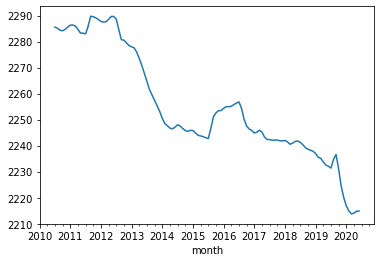

In [12]:
# display seasonal decomposition charts using the statsmodels package
result = seasonal_decompose(df_total_month["size"],  model='additive')
# plotting trend (seasonally adjusted)
result.trend.plot()

<AxesSubplot:xlabel='month'>

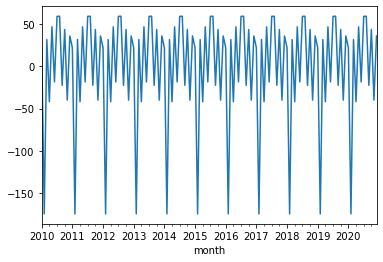

In [7]:
result.seasonal.plot()

From the seasonal plot of our seasonal decomposition, there appears to be a clear seasonal component in our data. We can also see a negative linear trend once the seasonality component has been ignored. To account for seasonality of our model not just for the month, we have added categorical variables for: year, month, and day, in our pre-processed dataset above.

count    120.000000
mean      -0.300694
std       16.561686
min      -66.100694
25%       -7.921528
50%       -0.213194
75%        8.330556
max       85.578472
Name: resid, dtype: float64


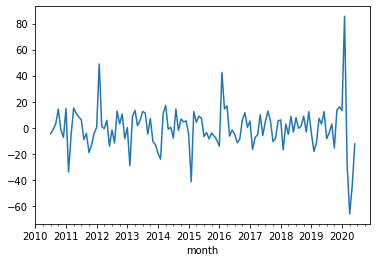

In [8]:
result.resid.plot()
print(result.resid.describe())

The mean of our residuals is approximately zero, suggesting that trend information captured by the seasonal decomposition is mostly accurate. Given the results of our exploratory analysis, an ARIMA model should may provide decent forecasting results. Lets check if our time series data is stationary using the ADF test.

In [17]:
# ADF test
def adfuller_test(sales):
    res = adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value, label in zip(res, labels):
        print(label+' : '+str(value) )

adfuller_test(df_total_month['size'])

ADF Test Statistic : -0.3183284769604939
p-value : 0.9228680590286779
#Lags Used : 12
Number of Observations : 119


p-value is greater than .05, data accepts the null. From ADF test we can see that the data is non-stationary, we will have to adjust.

## Model <a name="Model"></a>


## Results <a name="Results"></a>

## Conclusion <a name="Conclusion"></a>
